In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

In [15]:
tf.get_logger().setLevel('ERROR')

In [16]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

In [17]:
import os

# folders = ("H", "S", "U", "FG", "OP", "P", "C")
folders = ("H", "S", "U")

num_skipped = 0
for folder_name in folders:
    folder_path = os.path.join("Signs", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("PNG") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [18]:
image_size = (64, 40)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "Signs",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "Signs",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 6228 files belonging to 3 classes.
Using 4983 files for training.
Found 6228 files belonging to 3 classes.
Using 1245 files for validation.


In [19]:
class_names = train_ds.class_names
print(class_names)

['H', 'S', 'U']


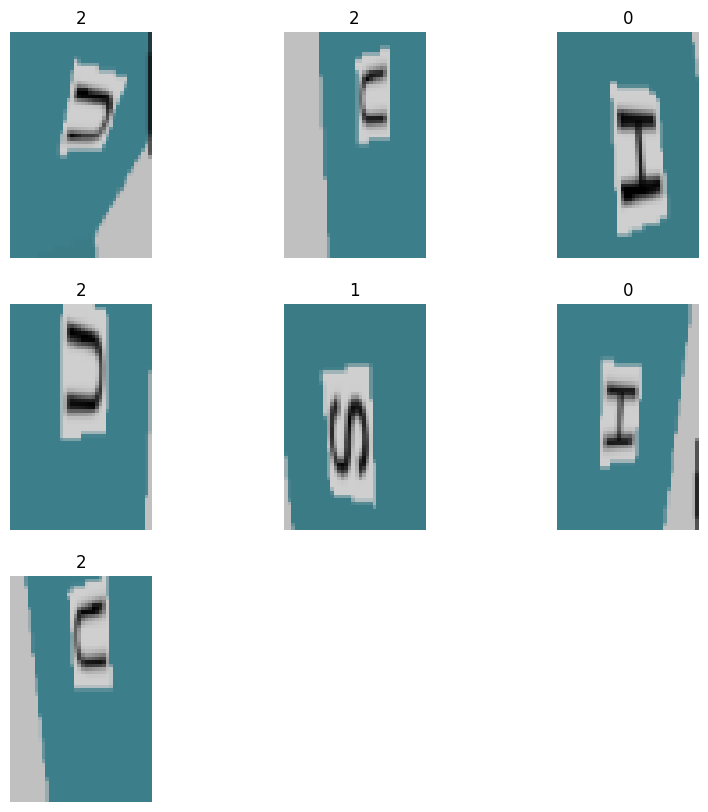

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(7):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [21]:
data_augmentation = keras.Sequential(
    [
        layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="constant"),
        layers.RandomFlip("horizontal",
                      input_shape=image_size + (3,)),
        layers.RandomZoom(0.1),
    ]
)

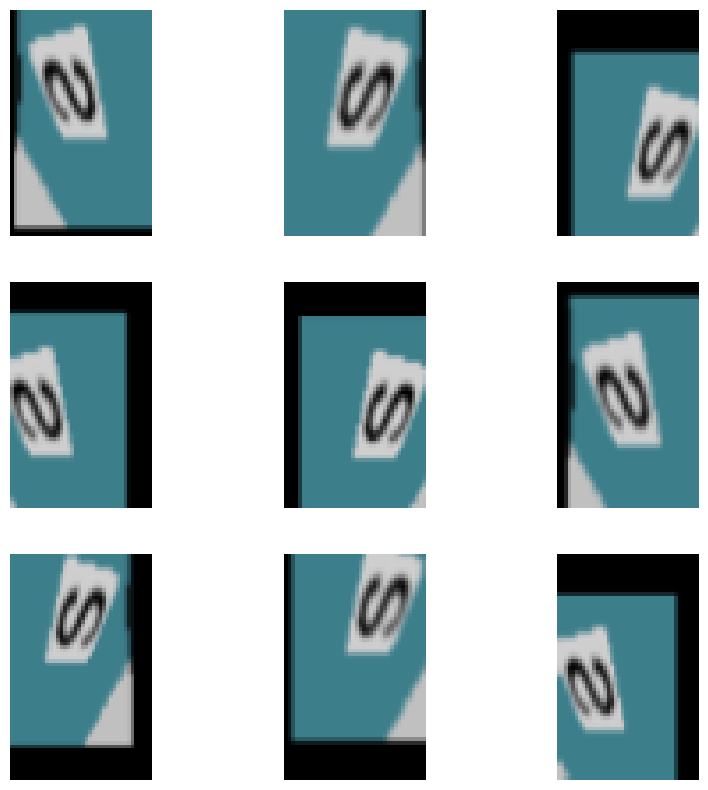

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [23]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [24]:
def make_tf_simple_model(input_shape, num_classes):
    model = keras.Sequential([
      data_augmentation,
      layers.Rescaling(1./255, input_shape=input_shape),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes, name="outputs")
    ])
    
    return model

In [25]:
model = make_tf_simple_model(input_shape=image_size + (3,), num_classes=len(folders))

default_epochs = 50

In [26]:
def fit_tf_simple_model(epochs = 50):
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
    )
    
    return history

In [27]:
# history = fit_model(default_epochs)
history = fit_tf_simple_model(default_epochs)

Epoch 1/50
156/156 [==============================] - 6s 24ms/step - loss: 0.8754 - accuracy: 0.5356 - val_loss: 0.8896 - val_accuracy: 0.6185
Epoch 2/50
156/156 [==============================] - 4s 26ms/step - loss: 0.4334 - accuracy: 0.8051 - val_loss: 0.4167 - val_accuracy: 0.9116
Epoch 3/50
156/156 [==============================] - 4s 26ms/step - loss: 0.2189 - accuracy: 0.9069 - val_loss: 0.0842 - val_accuracy: 0.9783
Epoch 4/50
156/156 [==============================] - 4s 26ms/step - loss: 0.1933 - accuracy: 0.9139 - val_loss: 0.0497 - val_accuracy: 0.9791
Epoch 5/50
156/156 [==============================] - 4s 27ms/step - loss: 0.1629 - accuracy: 0.9270 - val_loss: 0.0432 - val_accuracy: 0.9791
Epoch 6/50
156/156 [==============================] - 4s 27ms/step - loss: 0.1659 - accuracy: 0.9298 - val_loss: 0.0364 - val_accuracy: 0.9847
Epoch 7/50
156/156 [==============================] - 4s 28ms/step - loss: 0.1462 - accuracy: 0.9376 - val_loss: 0.0782 - val_accuracy: 0.9703

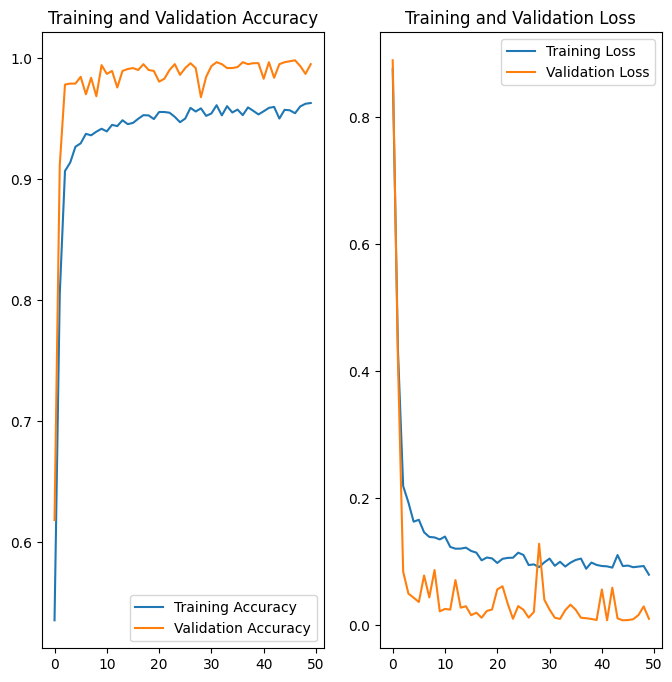

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(default_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
model.save('test_2.keras')

In [30]:
img = keras.preprocessing.image.load_img(
    "Signs/S/55.png", target_size=image_size
)

In [31]:
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

start = time.process_time() 
predictions = model.predict(img_array)
end = time.process_time()

print("Time: {}s".format(end-start)) 
print(list(map(lambda p, c: (c, p),predictions[0], class_names)))

1/1 [==============================] - 0s 59ms/step
Time: 0.0807320000000118s
[('H', -13.392569), ('S', 25.950258), ('U', -33.86764)]
